# Studies of data reuse: Electrophysiological recordings of striatal projection neurons (v1)

In this notebook we will look more closely at the EBRAINS dataset "[Electrophysiological recordings of striatal projection neurons (v1)](https://search.kg.ebrains.eu/instances/f25ec9c9-2348-4a62-a6af-907d389f263d)", contributed by Sten Grillner from the Department of Department of Neuroscience, Karolinska Institutet, Stockholm.

As we can see from the dataset description,

The study entails the collection of single cell patch-clamp recordings, done in conjunction with morphological reconstructions, from cholinergic interneurons in the striatum.
More information is available in the [Data Descriptor](https://search.kg.ebrains.eu/instances/f25ec9c9-2348-4a62-a6af-907d389f263d).

This dataset forms part of the results reported in Hjorth JJJ, Kozlov A, Carannante I, Frost Nylén J, Lindroos R, Johansson Y, Tokarska A, Dorst MC, Suryanarayana SM, Silberberg G, Hellgren Kotaleski J, Grillner S. The microcircuits of striatum in silico. *Proc Natl Acad Sci U S A*. 2020 Apr 28;**117**(17):9554-9565. https://doi.org/10.1073/pnas.2000671117

In this notebook we will demonstrate how to access the data files and the metadata from this study, and how these data can be analysed and visualised, with the goal of reproducing some of the figures from the article.

### Notes: 
Didn't have enough time to explore but this notebook is an example of the code that was provided by the researchers. It is very complete as it explains the data and shows how we can exploit it so I am almost certain that it would be very easy to reproduce figures used in the publication. 

In [ ]:
<h3 align="right">150917_c10_D1</h3>

# Electrophysiology feature extraction

* _Experimental data:_ Yvonne Johansson, Silberberg Laboratory, Department of Neuroscience, Karolinska Institute.

* _Feature extraction:_ Alexander Kozlov, Grillner Laboratory, Department of Neuroscience, Karolinska Institute.

* _Software:_ Electrophys Feature Extraction Library, eFEL (github/BlueBrain).

## Experimental data

In [1]:
cell_type = 'MSN_D1'
cell_path = '../../derived/MSN/'
cell_id = '150917_c10_D1'
cell = cell_path + cell_id
prefix = 'ECBL'
channels = {'current': 2, 'voltage': 3}
liquid_junction_potential = 9.5

In [2]:
spec = {}
spec['cell_id'] = cell_id
spec['cell_type'] = cell_type
spec['cell_features'] = {}
spec['temperature'] = 35
spec['liquid_junction_potential'] = liquid_junction_potential

In [3]:
config = []

## Programming environment

In [4]:
from __future__ import print_function, division
import efel
import json
import pandas
import numpy as np

In [5]:
#%matplotlib notebook
%matplotlib inline

In [6]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams.update({'font.size': 8})

In [7]:
figs = []

In [8]:
def plot_traces(path, prefix, protocol, channels, recordings,
                vshift=0, title=None, figsize=(12, 8)):
    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=figsize)
    ax1.set_ylabel('Voltage (mV)')
    ax2.set_ylabel('Current (pA)')
    ax2.set_xlabel('Time (ms)')
    if not title:
        title = protocol
    fig.suptitle(title)
    if len(recordings) > 1:
        color_cycle = [plt.cm.Blues(i) 
                       for i in np.linspace(0.3, 1, len(recordings))**2]
        ax1.set_prop_cycle('color', color_cycle)
        ax2.set_prop_cycle('color', color_cycle)
    for rec in reversed(recordings):
        fullname = path + '/' + prefix + '_' + protocol \
            + '_ch' + str(channels['current']) + '_' + str(rec) + '.dat'
        data = np.loadtxt(fullname)
        time = data[:, 0]
        current = data[:, 1]
        fullname = path + '/' + prefix + '_' + protocol \
            + '_ch' + str(channels['voltage']) + '_' + str(rec) + '.dat'
        data = np.loadtxt(fullname)
        voltage = data[:, 1] - vshift
        ax1.plot(time, voltage)
        ax2.plot(time, current)
    return fig

In [9]:
def get_currents(path, prefix, protocol, channels, recordings, timing):
    currents = []
    for rec in recordings:
        fullname = path + '/' + prefix + '_' + protocol \
            + '_ch' + str(channels['current']) + '_' + str(rec) + '.dat'
        data = np.loadtxt(fullname)
        time = data[:, 0]
        current = data[:, 1]
        hold = current[np.where(time < timing['stimulus_start'])].mean()
        stim = current[np.where((timing['stimulus_start'] < time) 
                        & (time < timing['stimulus_end']))].mean()
        current = {}
        current['sweep'] = protocol + '_' + str(rec)
        current['holding_current_amp'] = hold
        current['holding_current_start'] = time[0]
        current['holding_current_end'] = time[-1]
        current['stimulus_total_amp'] = stim
        current['stimulus_amp'] = stim - hold
        current['stimulus_start'] = timing['stimulus_start']
        current['stimulus_end'] = timing['stimulus_end']
        currents.append(current)
    return currents

In [10]:
def extract(features, path, prefix, protocol, channels, recordings, timing,
            vshift=0, input_resistance=False):    
    stimuli = get_currents(path, prefix, protocol, channels, recordings, timing)
    traces = []
    for rec in recordings:
        fullname = path + '/' + prefix + '_' + protocol \
            + '_ch' + str(channels['voltage']) + '_' + str(rec) + '.dat'
        data = np.loadtxt(fullname)
        time = data[:, 0]
        voltage = data[:, 1] - vshift
        trace = {}
        trace['T'] = time
        trace['V'] = voltage
        trace['stim_start'] = [timing['stimulus_start']]
        trace['stim_end'] = [timing['stimulus_end']]
        traces.append(trace)
    if input_resistance:
        pA = 1e-12
        mV = 1e-3
        MOhm = 1e6
        efel.setDoubleSetting('stimulus_current', 
                              stimuli[0]['stimulus_amp']/(mV/pA/MOhm))
    feature_values = efel.getFeatureValues(traces, features)
    res = [(s, f) for s, f in zip(stimuli, feature_values)]
    return res

In [11]:
def plot_table(stim_feature_data, title='', 
               stim_component='stimulus_total_amp', figsize=(12, 8)):
    fig = plt.figure(figsize=figsize)
    ax = plt.subplot()
    ax.axis('off')
    index = ['%s: %.2f' % (s['sweep'], s[stim_component]) for s, f in stim_feature_data]
    d = [f.values() for s, f in stim_feature_data]
    columns = f.keys()
    df = pandas.DataFrame(d, index=index, columns=columns)
    dfm = df.applymap(np.mean)
    ax.table(cellText=np.round(dfm.values, 2), loc='center',
             rowLabels=dfm.index, colLabels=range(len(columns)))
    legend = title + '\n\n'
    for i, x in enumerate(columns):
        legend += "%d:%s " % (i, x)
        if i%4 == 3: legend += '\n'
    plt.text(0, 0.9, legend, horizontalalignment='left')
    fig.tight_layout(rect=(.2,0,1,1))
    return fig

In [12]:
def save_figs(name, figs):
    from matplotlib.backends.backend_pdf import PdfPages
    with PdfPages(name + '-figs.pdf') as ofile:
        for fig in figs:
            ofile.savefig(fig)

class NumpyJSONEncoder(json.JSONEncoder):
    from json import JSONEncoder
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        return JSONEncoder.default(self, obj)
            
def save_spec(name, results):
    from json import dump
    with open(name + '-spec.json', 'w') as ofile:
        dump(results, ofile, cls=NumpyJSONEncoder, indent=4)

def save_summary(name, summary):
    from json import dump
    with open(name + '-sum.json', 'w') as ofile:
        dump(summary, ofile, sort_keys=True, indent=4)

In [13]:
def save_protocols(config, spec):
    import collections
    pA = 1e-12
    nA = 1e-9
    protocols = collections.OrderedDict()
    for c in sorted(config, key=lambda c: c['feature_protocol'] + '_' + str(c['ref_trace'])):
        sweep = c['exp_protocol'] + '_' + str(c['ref_trace'])
        run = c['feature_protocol'] + '_' + str(c['ref_trace'])
        for s, f in spec['cell_features'][c['feature_protocol']]:
            if s['sweep'] == sweep: break
        protocols[run] = {
            'stimuli': [
                {
                    'amp': s['stimulus_amp'] /(nA/pA),
                    'delay': s['stimulus_start'],
                    'duration': s['stimulus_end'] - s['stimulus_start'],
                    'totduration': s['holding_current_end']
                },
                {
                    'amp': s['holding_current_amp'] /(nA/pA),
                    'delay': s['holding_current_start'],
                    'duration': s['holding_current_end'] - s['holding_current_start'],
                    'totduration': s['holding_current_end']
                }
            ]
        }
        
    for run in protocols:
        for i, stim in enumerate(protocols[run]['stimuli']):
            for name in stim.keys():
                if name in ['delay', 'duration', 'totduration']:
                    protocols[run]['stimuli'][i][name] = round(protocols[run]['stimuli'][i][name], 0)
                else:
                    protocols[run]['stimuli'][i][name] = round(protocols[run]['stimuli'][i][name], 4)

    import json
    name = spec['cell_id'] + '-protocols.json'
    with open(name, 'w') as fp:
        json.dump(protocols, fp, indent=4)

In [14]:
def save_features(config, spec):
    import collections
    features = collections.OrderedDict()
    for c in sorted(config, key=lambda c: c['feature_protocol'] + '_' + str(c['ref_trace'])):
        run = c['feature_protocol'] + '_' + str(c['ref_trace'])
        feature_protocol = c['feature_protocol']
        features[run] = {'soma': collections.OrderedDict()}
        for f in sorted(spec['cell_features'][feature_protocol][0][1].keys()):
            features[run]['soma'][f] = []
            values = []
            for rec in c['repetitions']:
                sweep = c['exp_protocol'] + '_' + str(rec)
                for st, ft in spec['cell_features'][feature_protocol]:
                    if st['sweep'] == sweep:
                        feature_values = ft[f].tolist()
                        values.extend(feature_values)
            favg = np.array(values).mean()
            fstd = np.array(values).std() if len(values) > 1 else 0.1*abs(favg)
            fstd = 0.1 if fstd==0 else fstd
            features[run]['soma'][f].append(round(favg, 4))
            features[run]['soma'][f].append(round(fstd, 4))
    import json
    name = spec['cell_id'] + '-features.json'
    with open(name, 'w') as fp:
        json.dump(features, fp, indent=4)        

## APThreshold

In [15]:
protocol = 'APThreshold'
feature_protocol = protocol
repetitions = [[504]]

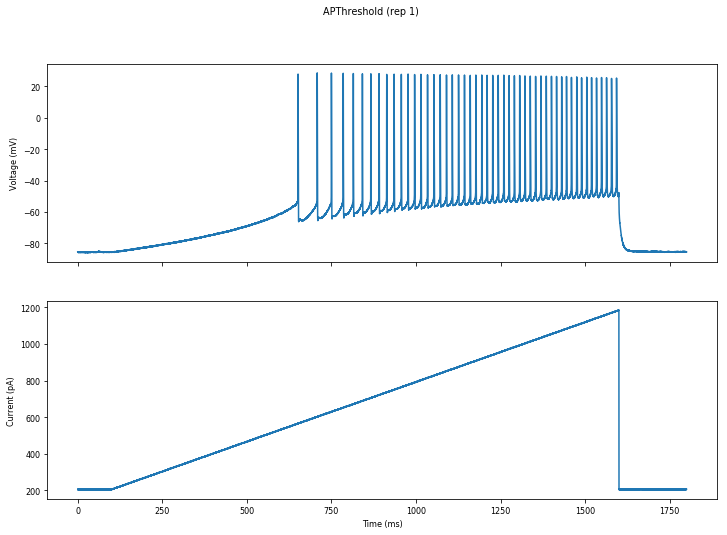

In [16]:
for recordings in repetitions[0:1]:
    fig = plot_traces(cell, prefix, protocol, channels, recordings, 
                      title=feature_protocol + ' (rep %d)' % len(repetitions),
                     vshift=liquid_junction_potential)
    figs.append(fig)

In [17]:
features = ['time_to_first_spike', 'AP1_begin_voltage', 
            'AP1_amp', 'APlast_amp', 'mean_AP_amplitude', 
            'inv_first_ISI', 'inv_last_ISI', 'ISI_log_slope', 'ISI_semilog_slope']

In [18]:
spec['cell_features'][feature_protocol] = []
for recordings in repetitions:
    res = extract(features, cell, prefix, protocol, channels, recordings, 
              timing={'stimulus_start': 100, 'stimulus_end': 1600},
             vshift=liquid_junction_potential, input_resistance=True)
    spec['cell_features'][feature_protocol].extend(res)

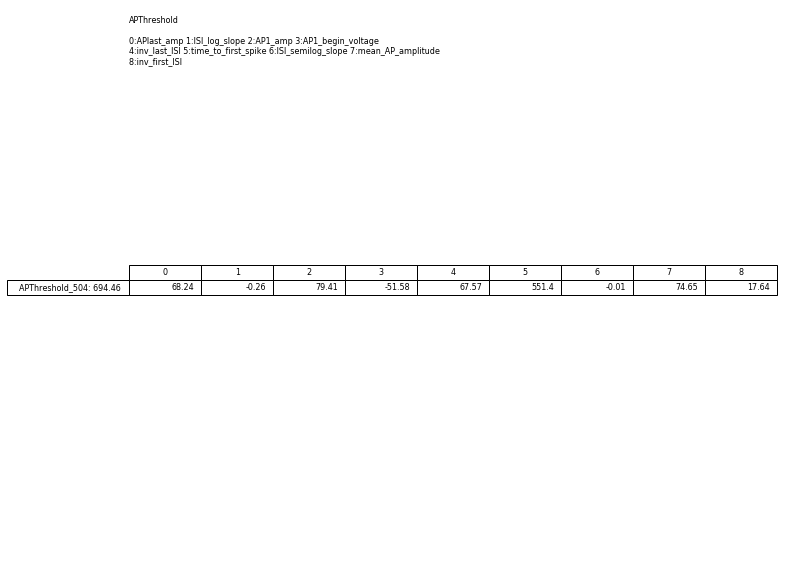

In [19]:
fig = plot_table(spec['cell_features'][feature_protocol][0:len(repetitions[0])], 
                 title=feature_protocol)
figs.append(fig)

## APWaveform

In [20]:
protocol = 'APWaveform'
feature_protocol = protocol
repetitions = [range(522, 522+6)]

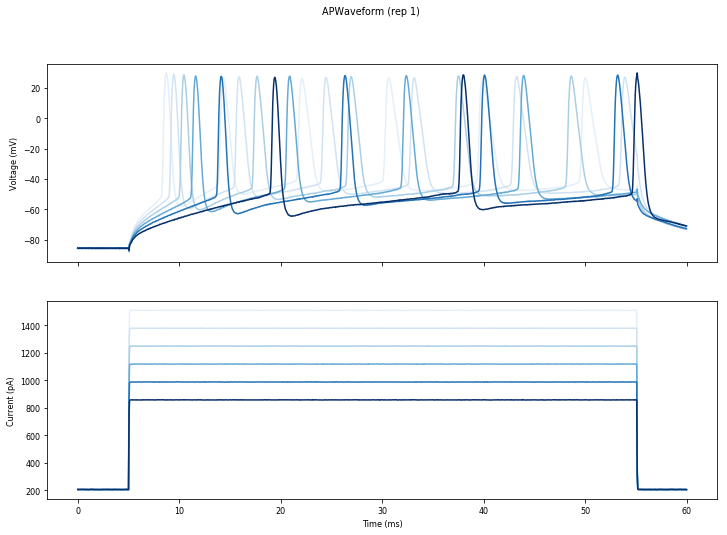

In [21]:
for recordings in repetitions[0:1]:
    fig = plot_traces(cell, prefix, protocol, channels, recordings, 
                      title=feature_protocol + ' (rep %d)' % len(repetitions),
                     vshift=liquid_junction_potential)
    figs.append(fig)

In [22]:
features_AP = ['AP_amplitude', 'AP_fall_rate', 'AP_begin_voltage',
               'AP_rise_rate', 'peak_voltage', 'spike_half_width',
               'AHP_depth', 'AHP_depth_abs', 'AHP_time_from_peak']
features = features_AP

In [23]:
spec['cell_features'][feature_protocol] = []
for recordings in repetitions:
    res = extract(features, cell, prefix, protocol, channels, recordings, 
              timing={'stimulus_start': 5, 'stimulus_end': 55},
                 vshift=liquid_junction_potential)
    spec['cell_features'][feature_protocol].extend(res)

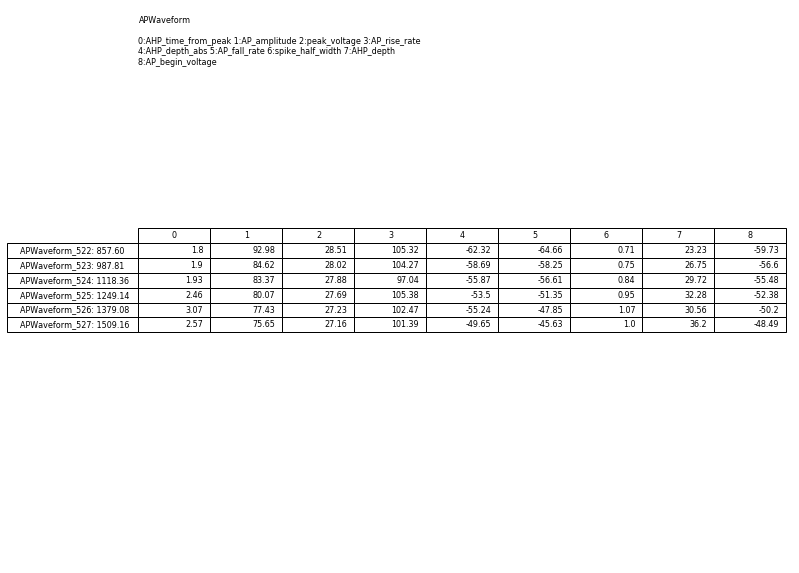

In [24]:
fig = plot_table(spec['cell_features'][feature_protocol][0:len(repetitions[0])], 
                 title=feature_protocol)
figs.append(fig)

In [25]:
for rec in repetitions[0]:
    select = {
        'feature_protocol': feature_protocol,
        'exp_protocol': protocol,
        'ref_trace': rec,
        'repetitions': [rec+len(repetitions[0])*i for i in range(len(repetitions))]
    }
    config.append(select)

## Delta

In [26]:
protocol = 'Delta'
feature_protocol = protocol
repetitions = [[569]]

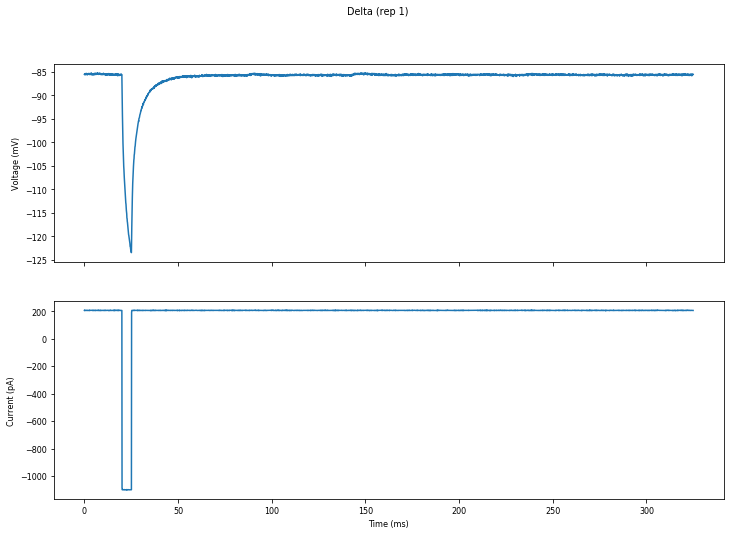

In [27]:
for recordings in repetitions[0:1]:
    fig = plot_traces(cell, prefix, protocol, channels, recordings, 
                      title=feature_protocol + ' (rep %d)' % len(repetitions),
                     vshift=liquid_junction_potential)
    figs.append(fig)

In [28]:
features_pas = ['voltage_base', 'steady_state_voltage',
                'steady_state_voltage_stimend', 'decay_time_constant_after_stim']
features = features_pas

In [29]:
spec['cell_features'][feature_protocol] = []
for recordings in repetitions:
    res = extract(features, cell, prefix, protocol, channels, recordings, 
              timing={'stimulus_start': 20, 'stimulus_end': 25},
             vshift=liquid_junction_potential, input_resistance=True)
    spec['cell_features'][feature_protocol].extend(res)

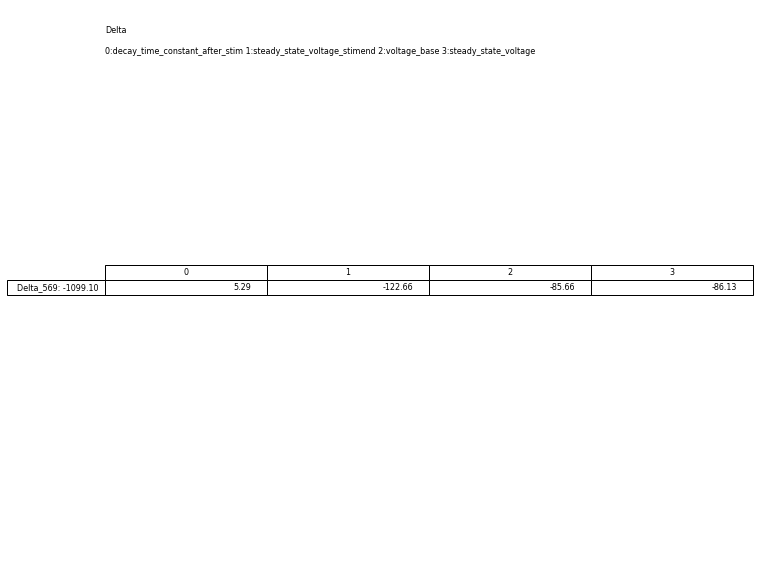

In [30]:
fig = plot_table(spec['cell_features'][feature_protocol][0:len(repetitions[0])], 
                 title=feature_protocol)
figs.append(fig)

In [31]:
for rec in repetitions[0]:
    select = {
        'feature_protocol': feature_protocol,
        'exp_protocol': protocol,
        'ref_trace': rec,
        'repetitions': [rec+len(repetitions[0])*i for i in range(len(repetitions))]
    }
    config.append(select)

## HighResThResp

In [32]:
protocol = 'HighResThResp'
feature_protocol = protocol
repetitions = [[566]]

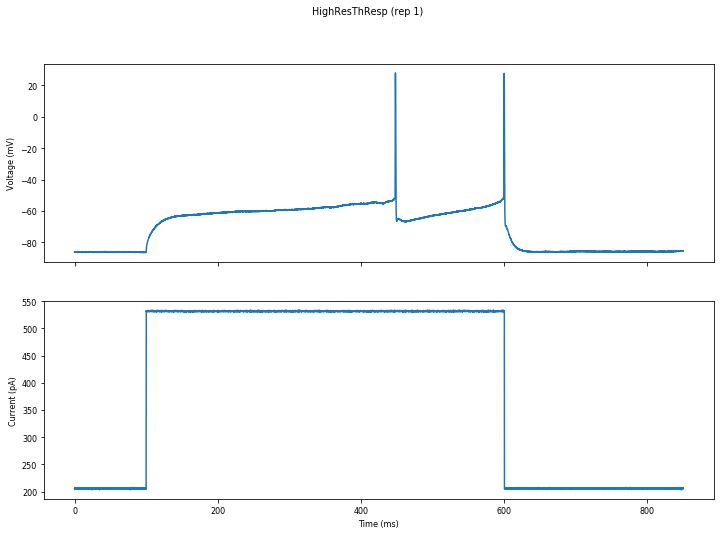

In [33]:
for recordings in repetitions[0:1]:
    fig = plot_traces(cell, prefix, protocol, channels, recordings, 
                      title=feature_protocol + ' (rep %d)' % len(repetitions),
                     vshift=liquid_junction_potential)
    figs.append(fig)

In [34]:
features = features_AP

In [35]:
spec['cell_features'][feature_protocol] = []
for recordings in repetitions:
    res = extract(features, cell, prefix, protocol, channels, recordings, 
              timing={'stimulus_start': 100, 'stimulus_end': 600},
                 vshift=liquid_junction_potential)
    spec['cell_features'][feature_protocol].extend(res)

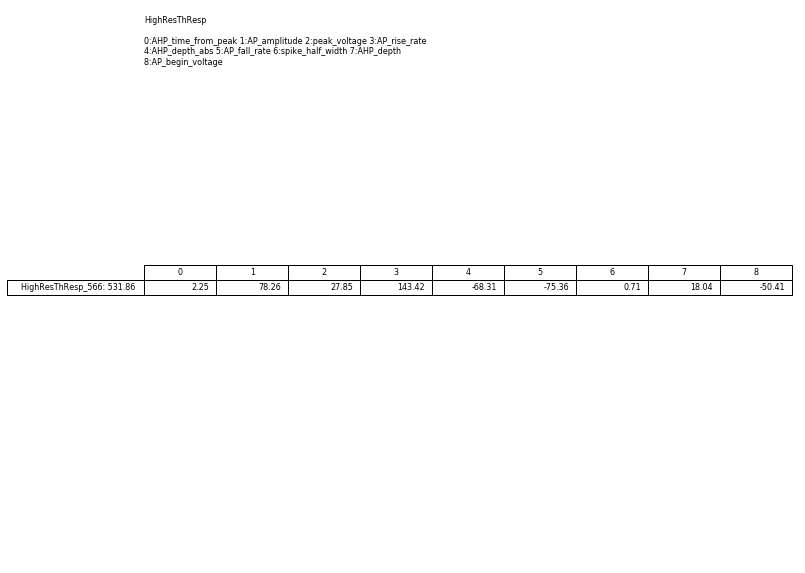

In [36]:
fig = plot_table(spec['cell_features'][feature_protocol][0:len(repetitions[0])], 
                 title=feature_protocol)
figs.append(fig)

In [37]:
for rec in repetitions[0]:
    select = {
        'feature_protocol': feature_protocol,
        'exp_protocol': protocol,
        'ref_trace': rec,
        'repetitions': [rec+len(repetitions[0])*i for i in range(len(repetitions))]
    }
    config.append(select)

## IDrest

In [38]:
protocol = 'IDrest'
feature_protocol = protocol
repetitions = [range(534, 544)]

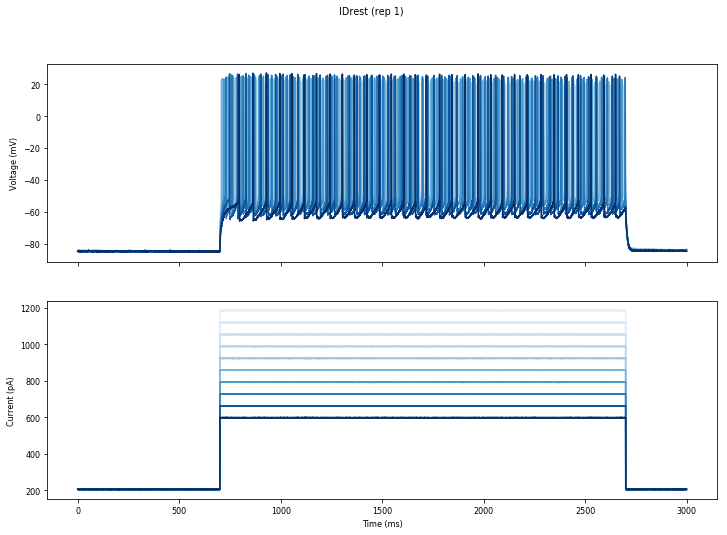

In [39]:
for recordings in repetitions[0:1]:
    fig = plot_traces(cell, prefix, protocol, channels, recordings, 
                      title=feature_protocol + ' (rep %d)' % len(repetitions),
                     vshift=liquid_junction_potential)
    figs.append(fig)

In [40]:
features_train = ['AHP_depth', 'AHP_depth_abs', 'AHP_depth_abs_slow',
                  'AHP_slow_time', 'AHP_time_from_peak', 'AP_amplitude',
                  'AP_begin_voltage', 'AP_fall_rate', 'AP_rise_rate', 
                  'ISI_CV', 'Spikecount', 'adaptation_index2', 
                  'inv_first_ISI', 'mean_frequency',
                  'min_voltage_between_spikes', 'peak_voltage', 
                  'spike_half_width', 'steady_state_voltage', 
                  'time_to_first_spike', 'voltage_base']
features = features_train

In [41]:
spec['cell_features'][feature_protocol] = []
for recordings in repetitions:
    res = extract(features, cell, prefix, protocol, channels, recordings, 
              timing={'stimulus_start': 700, 'stimulus_end': 2700},
                 vshift=liquid_junction_potential)
    spec['cell_features'][feature_protocol].extend(res)

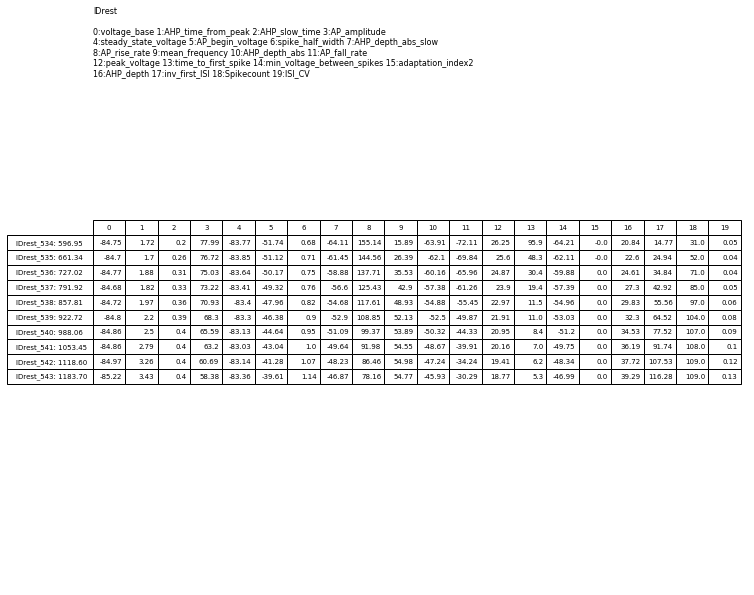

In [42]:
fig = plot_table(spec['cell_features'][feature_protocol][0:len(repetitions[0])], 
                 title=feature_protocol)
figs.append(fig)

In [43]:
for rec in repetitions[0]:
    select = {
        'feature_protocol': feature_protocol,
        'exp_protocol': protocol,
        'ref_trace': rec,
        'repetitions': [rec+len(repetitions[0])*i for i in range(len(repetitions))]
    }
    config.append(select)

## IDthresh (subthreshold)

In [44]:
protocol = 'IDthresh'
feature_protocol = 'IDthresh-sub'
repetitions = [range(544, 548)]

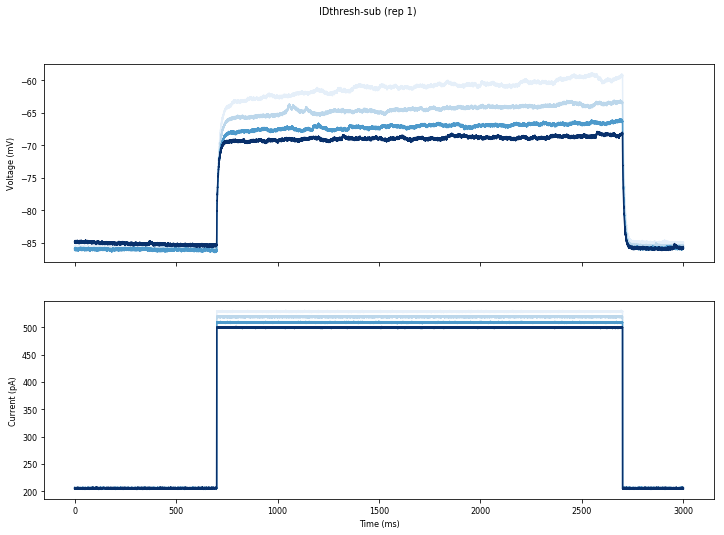

In [45]:
for recordings in repetitions[0:1]:
    fig = plot_traces(cell, prefix, protocol, channels, recordings, 
                      title=feature_protocol + ' (rep %d)' % len(repetitions),
                     vshift=liquid_junction_potential)
    figs.append(fig)

In [46]:
features_deflection = features_pas \
    + ['voltage_deflection', 'voltage_deflection_begin', 
       'voltage_deflection_vb_ssse', 'Spikecount']
features = features_deflection

In [47]:
spec['cell_features'][feature_protocol] = []
for recordings in repetitions:
    res = extract(features, cell, prefix, protocol, channels, recordings, 
              timing={'stimulus_start': 700, 'stimulus_end': 2700},
                 vshift=liquid_junction_potential)
    spec['cell_features'][feature_protocol].extend(res)

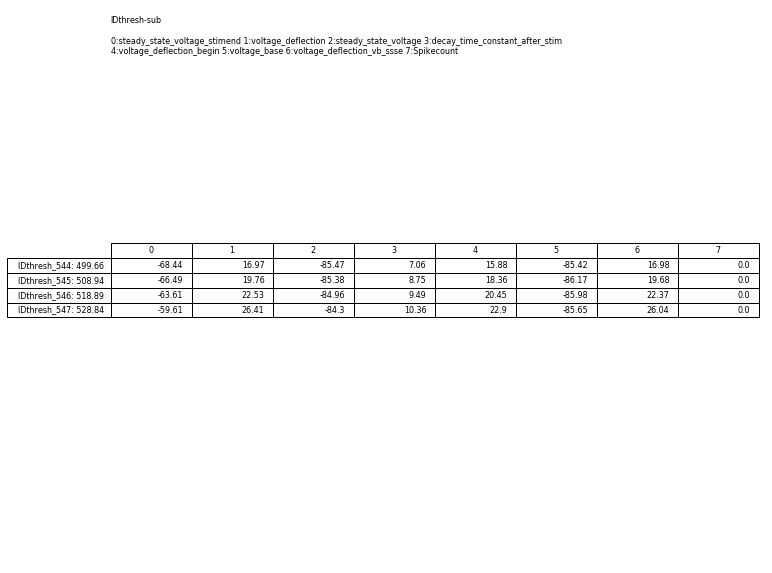

In [48]:
fig = plot_table(spec['cell_features'][feature_protocol][0:len(repetitions[0])], 
                 title=feature_protocol)
figs.append(fig)

In [49]:
for rec in repetitions[0]:
    select = {
        'feature_protocol': feature_protocol,
        'exp_protocol': protocol,
        'ref_trace': rec,
        'repetitions': [rec+len(repetitions[0])*i for i in range(len(repetitions))]
    }
    config.append(select)

## IDthresh

In [50]:
protocol = 'IDthresh'
feature_protocol = protocol
repetitions = [range(548, 565)]

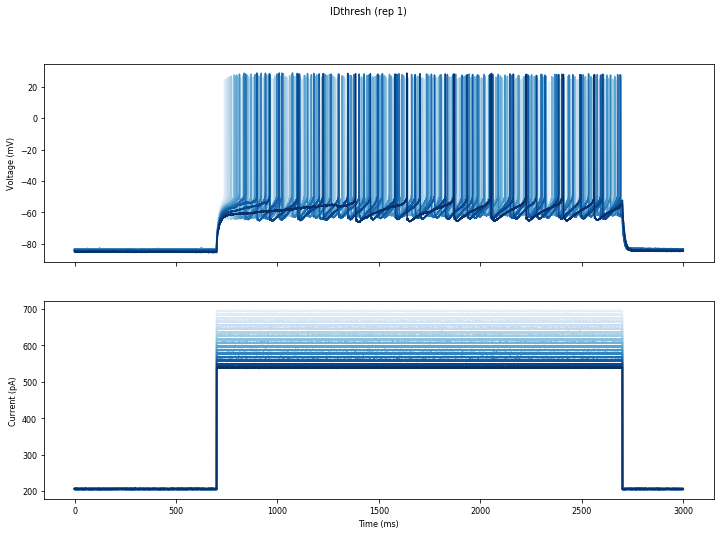

In [51]:
for recordings in repetitions[0:1]:
    fig = plot_traces(cell, prefix, protocol, channels, recordings, 
                      title=feature_protocol + ' (rep %d)' % len(repetitions),
                     vshift=liquid_junction_potential)
    figs.append(fig)

In [52]:
features = features_train

In [53]:
spec['cell_features'][feature_protocol] = []
for recordings in repetitions:
    res = extract(features, cell, prefix, protocol, channels, recordings, 
              timing={'stimulus_start': 700, 'stimulus_end': 2700},
                 vshift=liquid_junction_potential)
    spec['cell_features'][feature_protocol].extend(res)

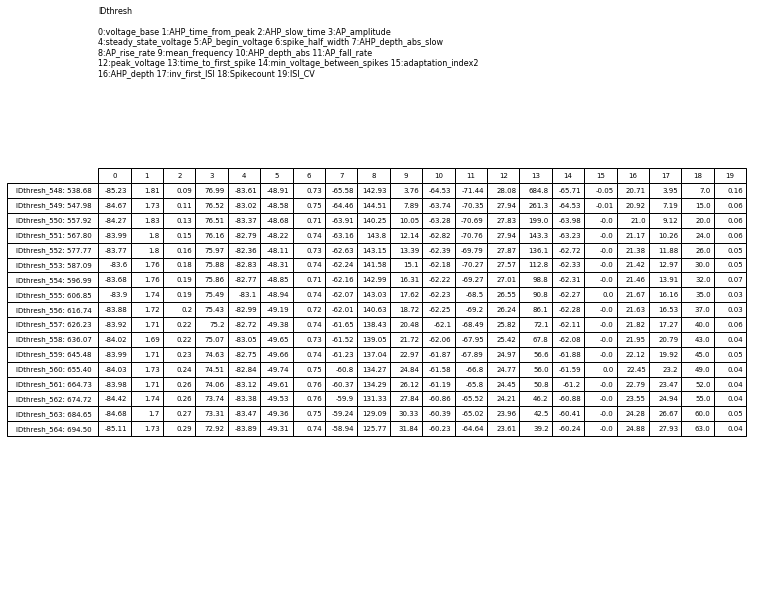

In [54]:
fig = plot_table(spec['cell_features'][feature_protocol][0:len(repetitions[0])], 
                 title=feature_protocol)
figs.append(fig)

In [55]:
for rec in repetitions[0]:
    select = {
        'feature_protocol': feature_protocol,
        'exp_protocol': protocol,
        'ref_trace': rec,
        'repetitions': [rec+len(repetitions[0])*i for i in range(len(repetitions))]
    }
    config.append(select)

## IRdepol

In [56]:
protocol = 'IRdepol'
feature_protocol = protocol
repetitions = [[521]]

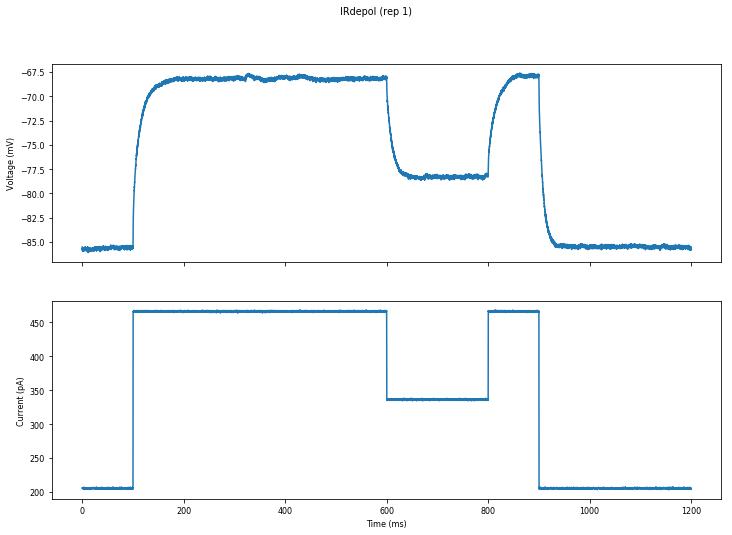

In [57]:
for recordings in repetitions[0:1]:
    fig = plot_traces(cell, prefix, protocol, channels, recordings, 
                      title=feature_protocol + ' (rep %d)' % len(repetitions),
                     vshift=liquid_junction_potential)
    figs.append(fig)

In [58]:
features_IR = ['voltage_base', 'steady_state_voltage_stimend', 'decay_time_constant_after_stim',
               'voltage_deflection_vb_ssse', 'ohmic_input_resistance_vb_ssse']
features = features_IR

In [59]:
spec['cell_features'][feature_protocol] = []
for recordings in repetitions:
    res = extract(features, cell, prefix, protocol, channels, recordings, 
              timing={'stimulus_start': 600, 'stimulus_end': 800},
             vshift=liquid_junction_potential, input_resistance=True)
    spec['cell_features'][feature_protocol].extend(res)

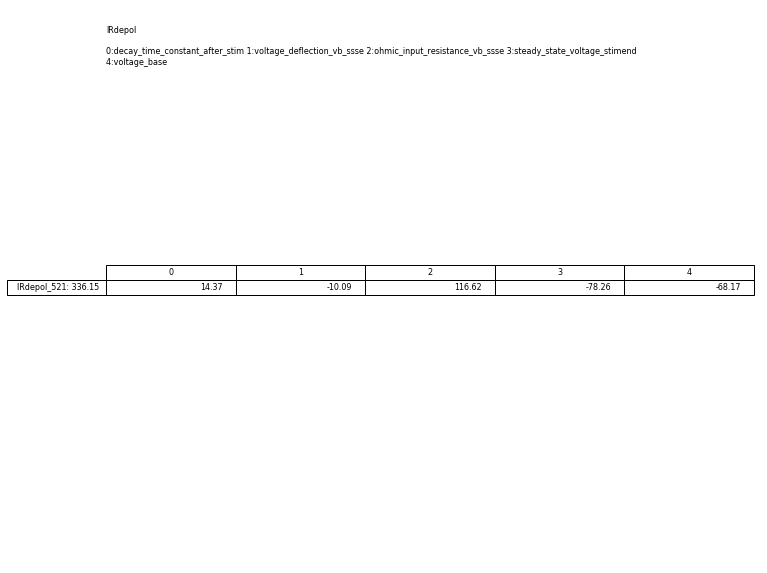

In [60]:
fig = plot_table(spec['cell_features'][feature_protocol][0:len(repetitions[0])], 
                 title=feature_protocol)
figs.append(fig)

## IRhyperpol

In [61]:
protocol = 'IRhyperpol'
feature_protocol = protocol
repetitions = [[520]]

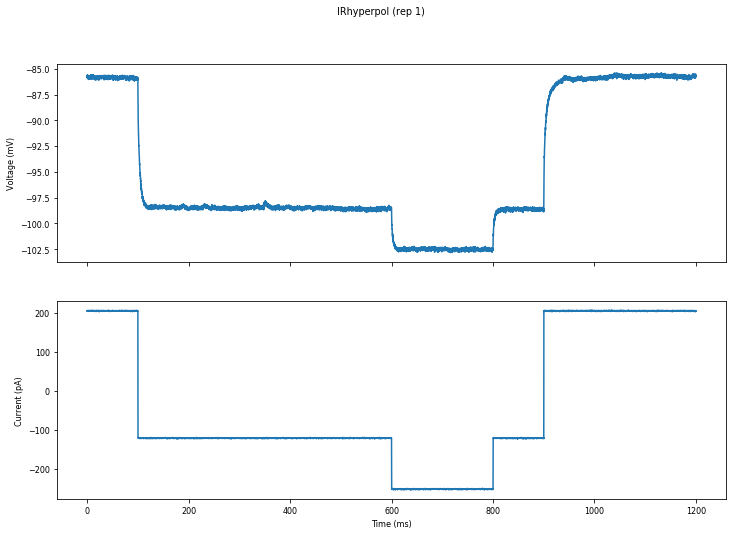

In [62]:
for recordings in repetitions[0:1]:
    fig = plot_traces(cell, prefix, protocol, channels, recordings, 
                      title=feature_protocol + ' (rep %d)' % len(repetitions),
                     vshift=liquid_junction_potential)
    figs.append(fig)

In [63]:
features = features_IR

In [64]:
spec['cell_features'][feature_protocol] = []
for recordings in repetitions:
    res = extract(features, cell, prefix, protocol, channels, recordings, 
              timing={'stimulus_start': 600, 'stimulus_end': 800},
             vshift=liquid_junction_potential, input_resistance=True)
    spec['cell_features'][feature_protocol].extend(res)

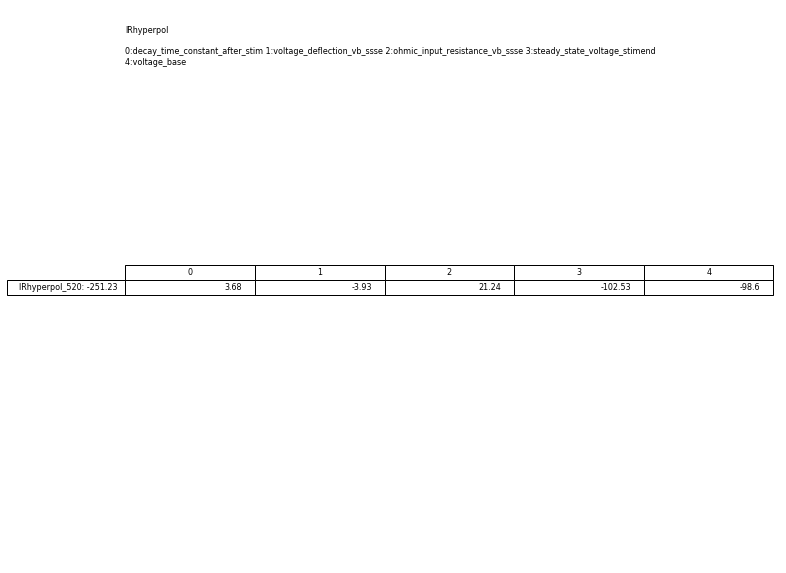

In [65]:
fig = plot_table(spec['cell_features'][feature_protocol][0:len(repetitions[0])], 
                 title=feature_protocol)
figs.append(fig)

## IRrest

In [66]:
protocol = 'IRrest'
feature_protocol = protocol
repetitions = [[519]]

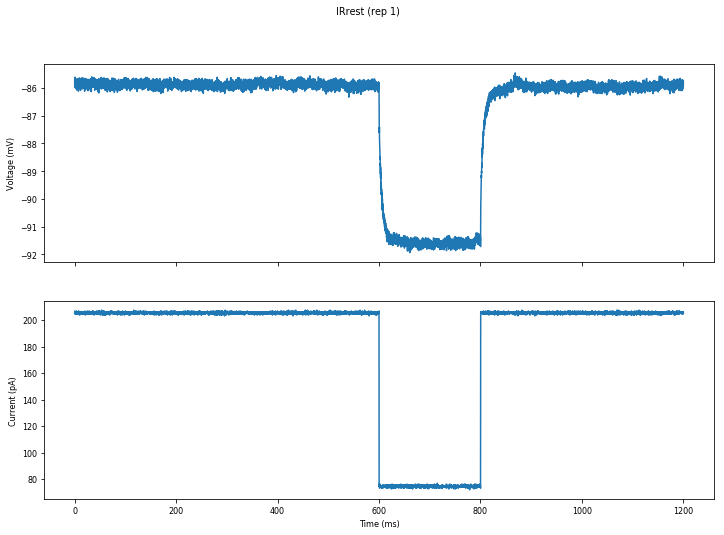

In [67]:
for recordings in repetitions[0:1]:
    fig = plot_traces(cell, prefix, protocol, channels, recordings, 
                      title=feature_protocol + ' (rep %d)' % len(repetitions),
                     vshift=liquid_junction_potential)
    figs.append(fig)

In [68]:
features = features_IR

In [69]:
spec['cell_features'][feature_protocol] = []
for recordings in repetitions:
    res = extract(features, cell, prefix, protocol, channels, recordings, 
              timing={'stimulus_start': 600, 'stimulus_end': 800},
             vshift=liquid_junction_potential, input_resistance=True)
    spec['cell_features'][feature_protocol].extend(res)

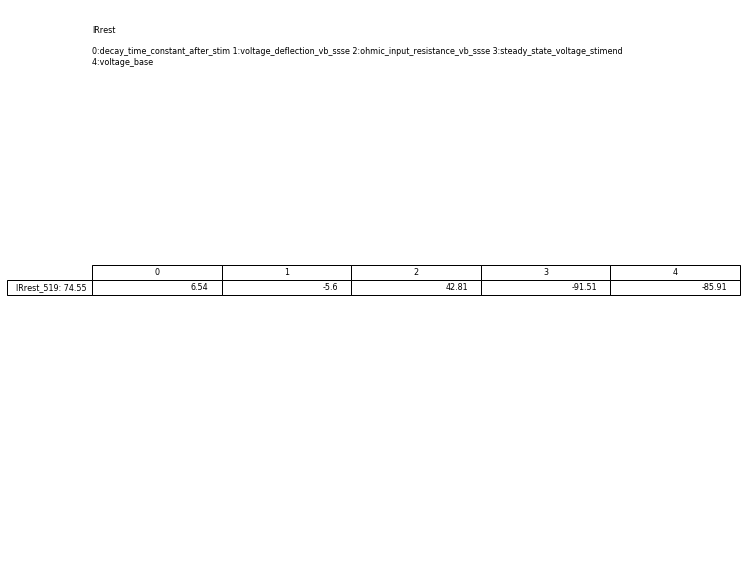

In [70]:
fig = plot_table(spec['cell_features'][feature_protocol][0:len(repetitions[0])], 
                 title=feature_protocol)
figs.append(fig)

## IV

In [71]:
protocol = 'IV'
feature_protocol = protocol
repetitions = [range(505, 517)]

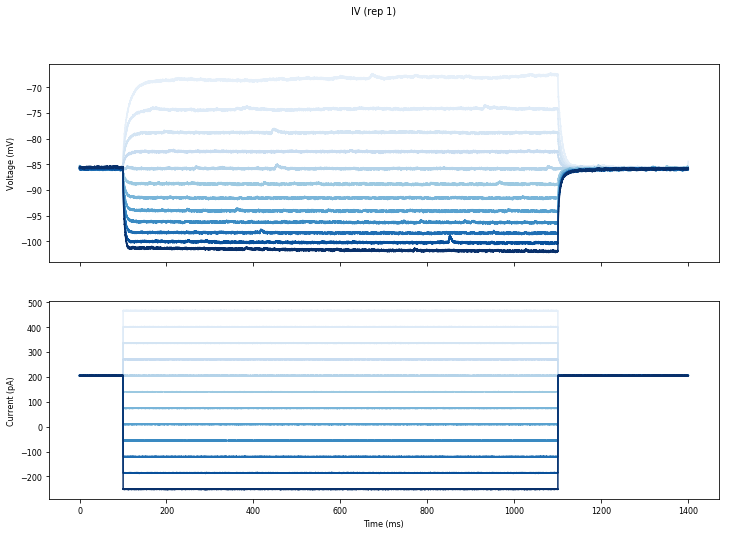

In [72]:
for recordings in repetitions[0:1]:
    fig = plot_traces(cell, prefix, protocol, channels, recordings, 
                      title=feature_protocol + ' (rep %d)' % len(repetitions),
                     vshift=liquid_junction_potential)
    figs.append(fig)

In [73]:
features = features_deflection

In [74]:
spec['cell_features'][feature_protocol] = []
for recordings in repetitions:
    res = extract(features, cell, prefix, protocol, channels, recordings, 
              timing={'stimulus_start': 100, 'stimulus_end': 1100},
                 vshift=liquid_junction_potential)
    spec['cell_features'][feature_protocol].extend(res)

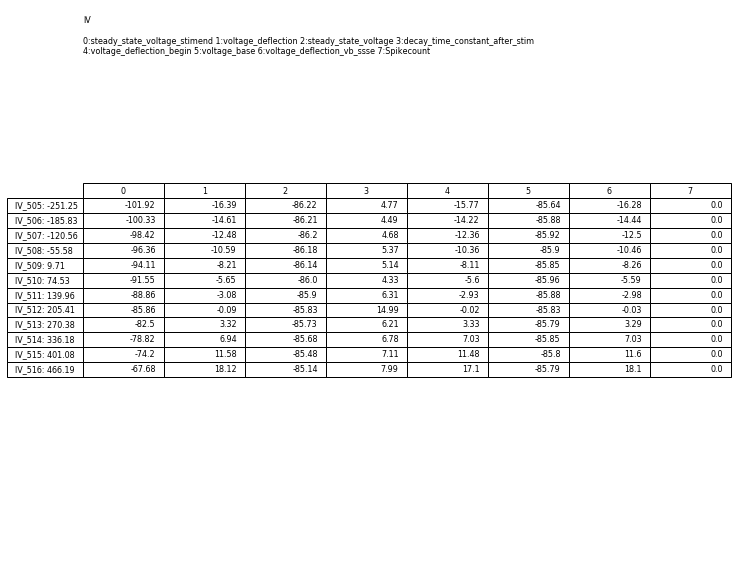

In [75]:
fig = plot_table(spec['cell_features'][feature_protocol][0:len(repetitions[0])], 
                 title=feature_protocol)
figs.append(fig)

In [76]:
for rec in repetitions[0]:
    select = {
        'feature_protocol': feature_protocol,
        'exp_protocol': protocol,
        'ref_trace': rec,
        'repetitions': [rec+len(repetitions[0])*i for i in range(len(repetitions))]
    }
    config.append(select)

## IV (suprathreshold)

In [77]:
protocol = 'IV'
feature_protocol = 'IV-supra'
repetitions = [[517, 518]]

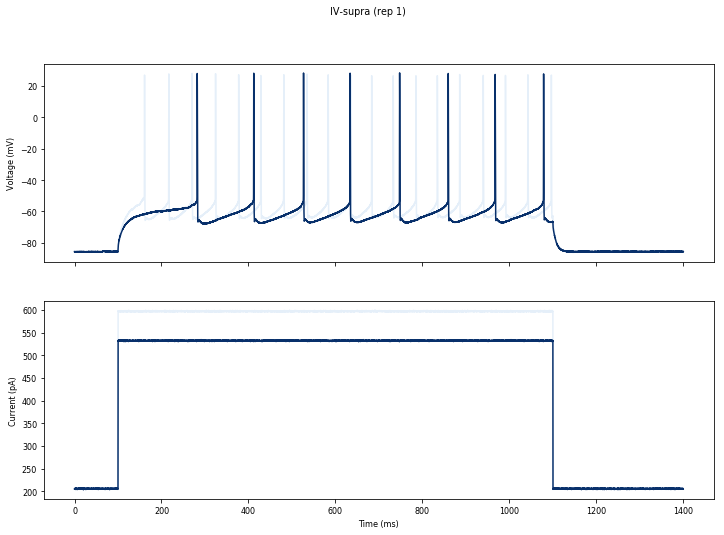

In [78]:
for recordings in repetitions[0:1]:
    fig = plot_traces(cell, prefix, protocol, channels, recordings, 
                      title=feature_protocol + ' (rep %d)' % len(repetitions),
                     vshift=liquid_junction_potential)
    figs.append(fig)

In [79]:
features = features_train

In [80]:
spec['cell_features'][feature_protocol] = []
for recordings in repetitions:
    res = extract(features, cell, prefix, protocol, channels, recordings, 
              timing={'stimulus_start': 100, 'stimulus_end': 1100},
                 vshift=liquid_junction_potential)
    spec['cell_features'][feature_protocol].extend(res)

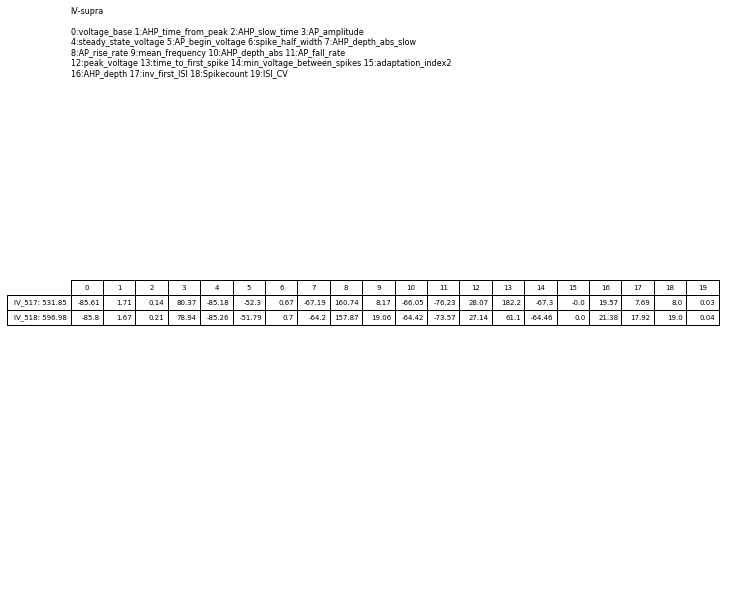

In [81]:
fig = plot_table(spec['cell_features'][feature_protocol][0:len(repetitions[0])], 
                 title=feature_protocol)
figs.append(fig)

In [82]:
for rec in repetitions[0]:
    select = {
        'feature_protocol': feature_protocol,
        'exp_protocol': protocol,
        'ref_trace': rec,
        'repetitions': [rec+len(repetitions[0])*i for i in range(len(repetitions))]
    }
    config.append(select)

## SpontAPs

In [83]:
protocol = 'SpontAPs'
feature_protocol = protocol
repetitions = [[567]]

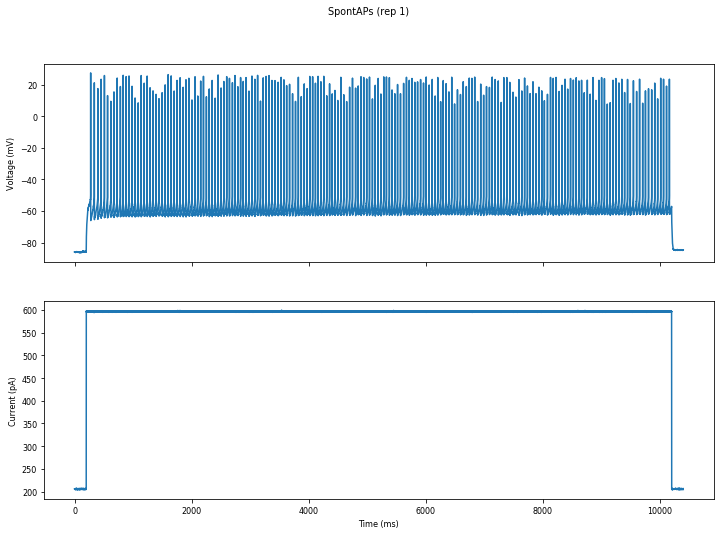

In [84]:
for recordings in repetitions[0:1]:
    fig = plot_traces(cell, prefix, protocol, channels, recordings, 
                      title=feature_protocol + ' (rep %d)' % len(repetitions),
                     vshift=liquid_junction_potential)
    figs.append(fig)

In [85]:
features = features_train

In [86]:
spec['cell_features'][feature_protocol] = []
for recordings in repetitions:
    res = extract(features, cell, prefix, protocol, channels, recordings, 
              timing={'stimulus_start': 200, 'stimulus_end': 10200},
                 vshift=liquid_junction_potential)
    spec['cell_features'][feature_protocol].extend(res)

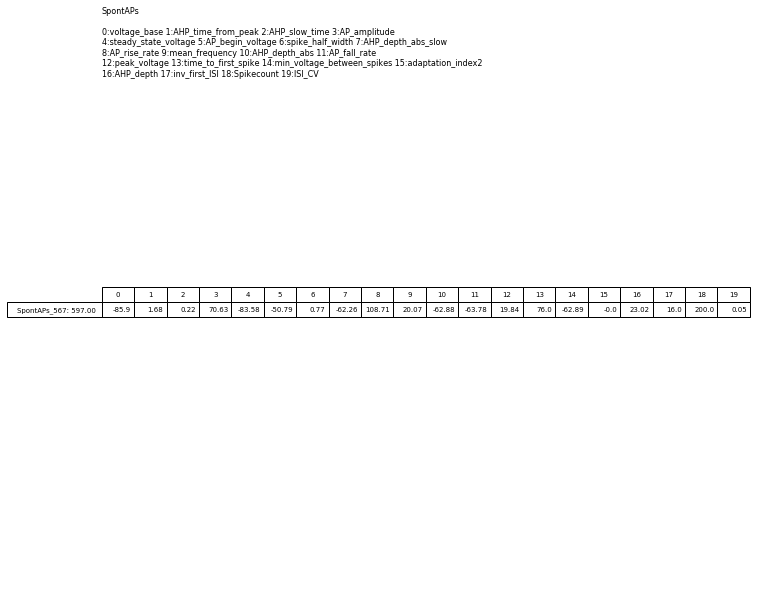

In [87]:
fig = plot_table(spec['cell_features'][feature_protocol][0:len(repetitions[0])], 
                 title=feature_protocol)
figs.append(fig)

## Spontaneous

In [88]:
protocol = 'Spontaneous'
feature_protocol = protocol
repetitions = [[565]]

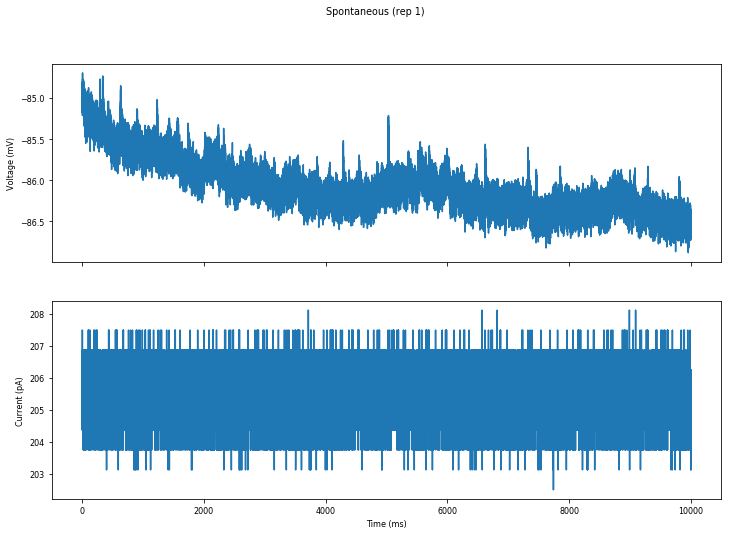

In [89]:
for recordings in repetitions[0:1]:
    fig = plot_traces(cell, prefix, protocol, channels, recordings, 
                      title=feature_protocol + ' (rep %d)' % len(repetitions),
                     vshift=liquid_junction_potential)
    figs.append(fig)

In [90]:
features = ['Spikecount', 'voltage_base', 'minimum_voltage', 'maximum_voltage']

In [91]:
spec['cell_features'][feature_protocol] = []
for recordings in repetitions:
    res = extract(features, cell, prefix, protocol, channels, recordings, 
              timing={'stimulus_start': 100, 'stimulus_end': 9000},
                 vshift=liquid_junction_potential)
    spec['cell_features'][feature_protocol].extend(res)

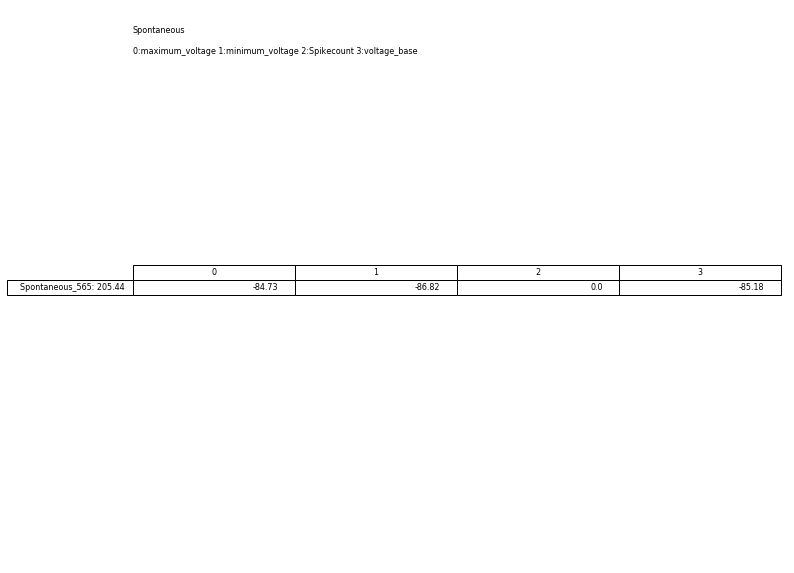

In [92]:
fig = plot_table(spec['cell_features'][feature_protocol][0:len(repetitions[0])], 
                 title=feature_protocol)
figs.append(fig)

## TesteCode (subthreshold)

In [93]:
protocol = 'TesteCode'
feature_protocol = 'TesteCode-sub'
repetitions = [[499]]

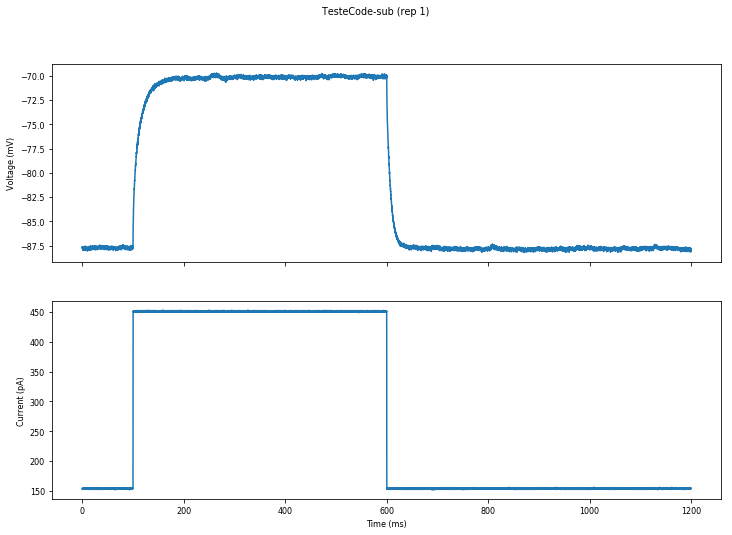

In [94]:
for recordings in repetitions[0:1]:
    fig = plot_traces(cell, prefix, protocol, channels, recordings, 
                      title=feature_protocol + ' (rep %d)' % len(repetitions),
                     vshift=liquid_junction_potential)
    figs.append(fig)

In [95]:
features = features_deflection

In [96]:
spec['cell_features'][feature_protocol] = []
for recordings in repetitions:
    res = extract(features, cell, prefix, protocol, channels, recordings, 
              timing={'stimulus_start': 100, 'stimulus_end': 600},
                 vshift=liquid_junction_potential)
    spec['cell_features'][feature_protocol].extend(res)

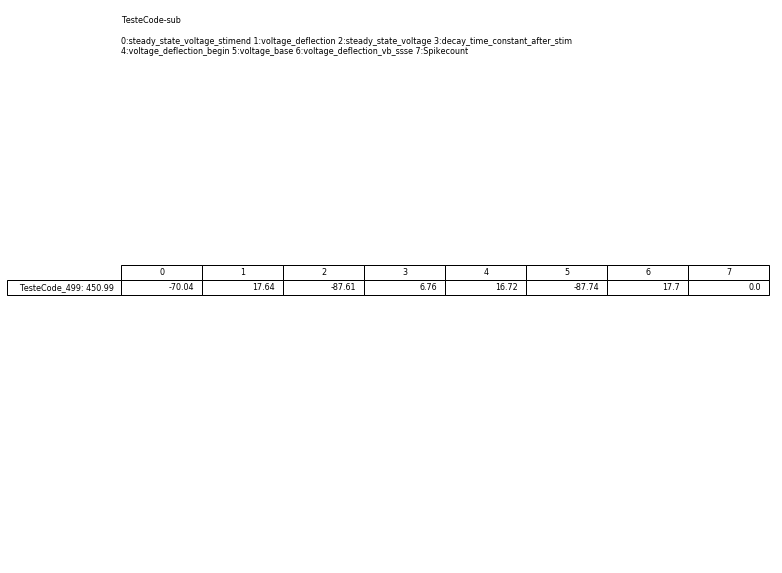

In [97]:
fig = plot_table(spec['cell_features'][feature_protocol][0:len(repetitions[0])], 
                 title=feature_protocol)
figs.append(fig)

## TesteCode

In [98]:
protocol = 'TesteCode'
feature_protocol = protocol
repetitions = [range(500, 504)]

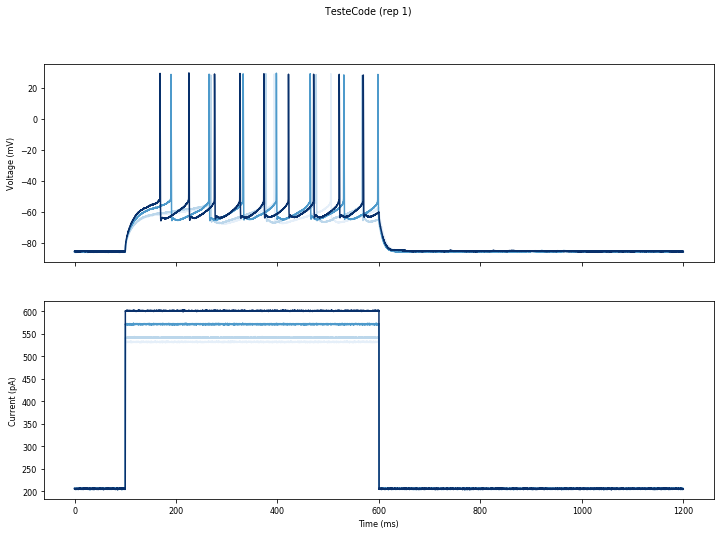

In [99]:
for recordings in repetitions[0:1]:
    fig = plot_traces(cell, prefix, protocol, channels, recordings, 
                      title=feature_protocol + ' (rep %d)' % len(repetitions),
                     vshift=liquid_junction_potential)
    figs.append(fig)

In [100]:
features = features_AP  # features_train

In [101]:
spec['cell_features'][feature_protocol] = []
for recordings in repetitions:
    res = extract(features, cell, prefix, protocol, channels, recordings, 
              timing={'stimulus_start': 100, 'stimulus_end': 600},
                 vshift=liquid_junction_potential)
    spec['cell_features'][feature_protocol].extend(res)

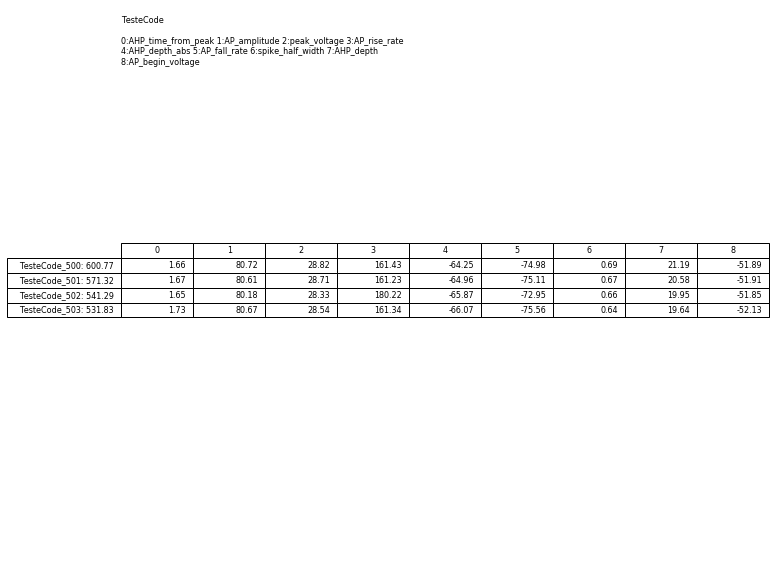

In [102]:
fig = plot_table(spec['cell_features'][feature_protocol][0:len(repetitions[0])], 
                 title=feature_protocol)
figs.append(fig)

## sAHP

In [103]:
protocol = 'sAHP'
feature_protocol = protocol
repetitions = [range(528, 534)]

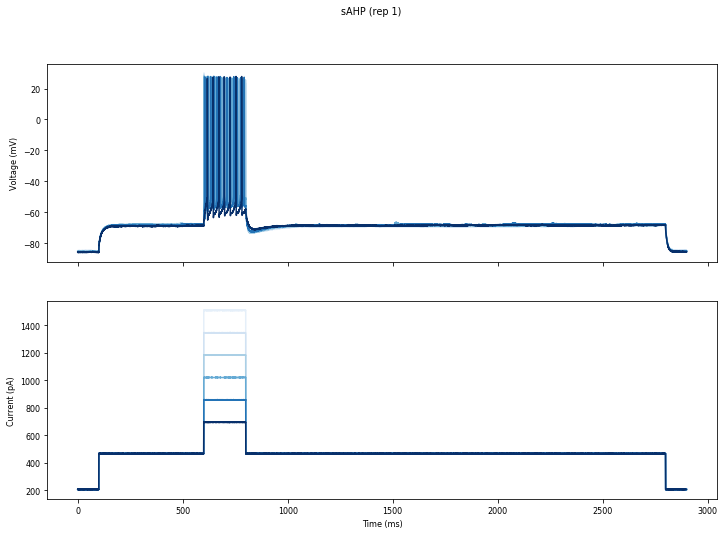

In [104]:
for recordings in repetitions[0:1]:
    fig = plot_traces(cell, prefix, protocol, channels, recordings,
                      title=feature_protocol + ' (rep %d)' % len(repetitions),
                     vshift=liquid_junction_potential)
    figs.append(fig)

In [105]:
features = ['Spikecount', 'voltage_base', 'mean_frequency']

In [106]:
# FIXME sAHP features are pending
spec['cell_features'][feature_protocol] = []
for recordings in repetitions:
    res = extract(features, cell, prefix, protocol, channels, recordings, 
              timing={'stimulus_start': 600, 'stimulus_end': 800},
                 vshift=liquid_junction_potential)
    #spec['cell_features'][feature_protocol].extend(res)
    res2 = extract(['minimum_voltage'], cell, prefix, protocol, channels, recordings, 
              timing={'stimulus_start': 800, 'stimulus_end': 2800},
                 vshift=liquid_junction_potential)
    for i in range(len(res)):
        res[i][1]['minimum_voltage'] = res2[i][1]['minimum_voltage']
    spec['cell_features'][feature_protocol].extend(res)

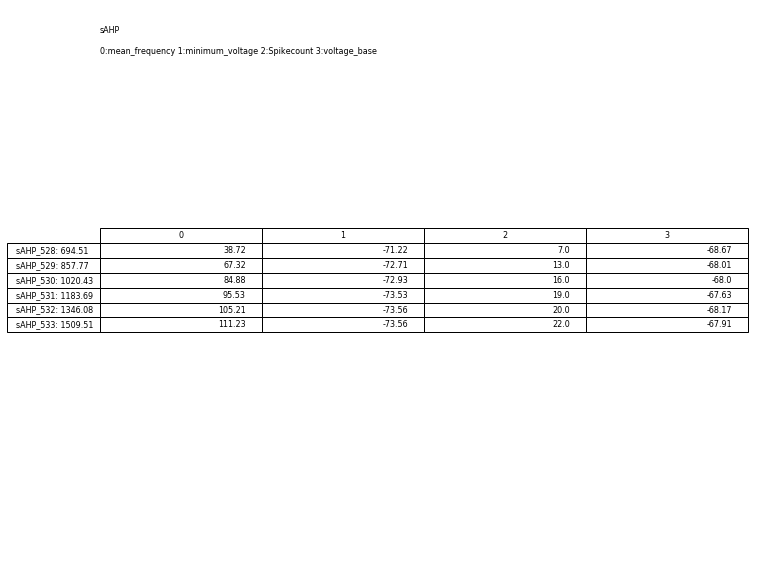

In [107]:
fig = plot_table(spec['cell_features'][feature_protocol][0:len(repetitions[0])], 
                 title=feature_protocol)
figs.append(fig)

In [108]:
for rec in repetitions[0]:
    select = {
        'feature_protocol': feature_protocol,
        'exp_protocol': protocol,
        'ref_trace': rec,
        'repetitions': [rec+len(repetitions[0])*i for i in range(len(repetitions))]
    }
    config.append(select)

## Summary

In [109]:
summary = {}

In [110]:
v_i = []
for stim, feat in spec['cell_features']['IV']:
    v_i.append((stim['stimulus_total_amp'], feat['steady_state_voltage_stimend'][0]))
for stim, feat in sorted(spec['cell_features']['IDthresh-sub'], key=lambda x: x[0], reverse=True)[-1::1]:
    v_i.append((stim['stimulus_total_amp'], feat['steady_state_voltage_stimend'][0]))
v_i.sort(key=lambda x: x[0])

In [111]:
from scipy.optimize import curve_fit

def fit(x, a, b, c, d):
    return a + b*x + np.exp((x-c)/d)

def dfit(x, a, b, c, d):
    return b + np.exp((x-c)/d)/d

xx = np.array([x[0] for x in v_i])
yy = np.array([x[1] for x in v_i])
popt, pcov = curve_fit(fit, xx, yy, bounds=([-10000,0,-10000,1], [0,0.1,1000,1000]))

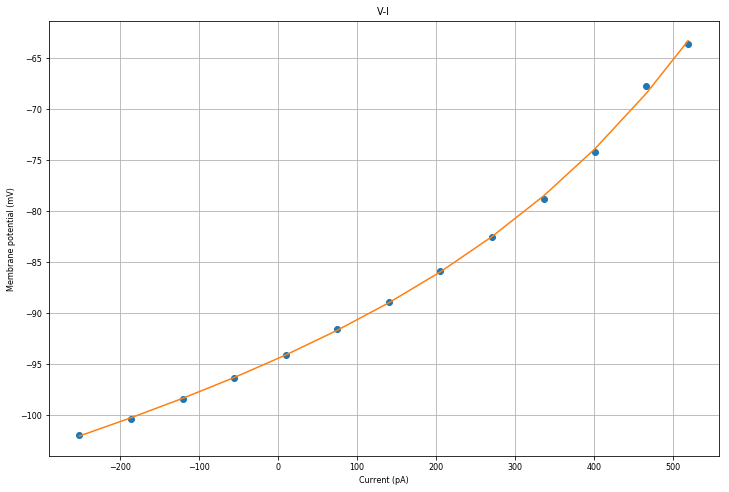

In [112]:
fig, ax = plt.subplots(figsize=(12,8))
ax.set_xlabel('Current (pA)')
ax.set_ylabel('Membrane potential (mV)')
ax.set_title('V-I')
ax.grid()
ax.plot(xx, yy, 'o')
ax.plot(xx, fit(xx, *popt))
figs.append(fig)

In [113]:
summary['vm_rest'] = fit(0, *popt)

In [114]:
slope = dfit(xx, *popt)

In [115]:
summary['ir_fitmin'] = min(slope)*1e3
summary['ir_fitmax'] = max(slope)*1e3
summary['ir_fitrest'] = dfit(0, *popt)*1e3

In [116]:
f_i = []
f_i1 = []
for stim, feat in spec['cell_features']['IDthresh']:
    f_i.append((stim['stimulus_total_amp'], feat['mean_frequency'][0]))
    f_i1.append((stim['stimulus_total_amp'], feat['inv_first_ISI'][0]))
f_i.sort(key=lambda x: x[0])
f_i1.sort(key=lambda x: x[0])

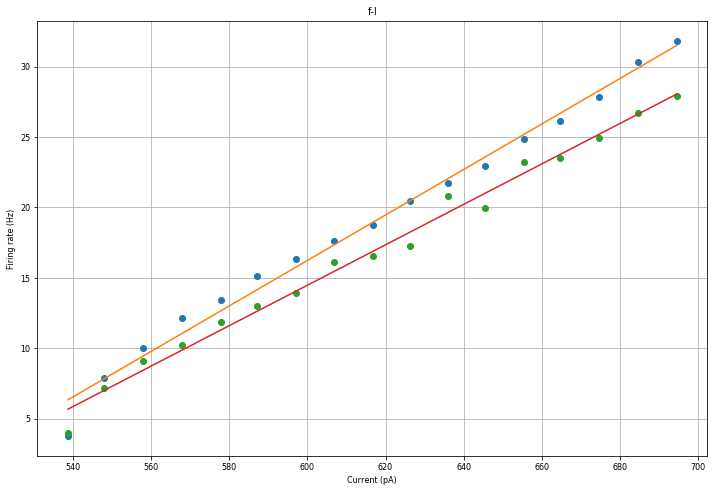

In [117]:
fig, ax = plt.subplots(figsize=(12,8))
ax.set_xlabel('Current (pA)')
ax.set_ylabel('Firing rate (Hz)')
ax.set_title('f-I')
ax.grid()
xx = np.array([x[0] for x in f_i])
yy = np.array([x[1] for x in f_i])
p = np.polyfit(xx, yy, 1)
ax.plot(xx, yy, 'o')
ax.plot(xx, p[1]+p[0]*xx, '-')
x1 = np.array([x[0] for x in f_i1])
y1 = np.array([x[1] for x in f_i1])
p1 = np.polyfit(x1, y1, 1)
ax.plot(x1, y1, 'o')
ax.plot(x1, p1[1]+p1[0]*x1, '-')
figs.append(fig)

Estimate rheobase current.

In [118]:
protocol = 'IDthresh'
repetitions = [[547, 548]]

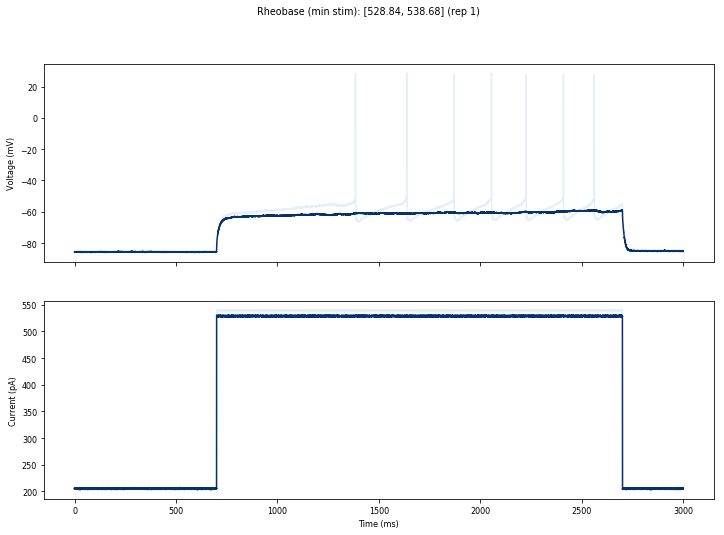

In [119]:
for recordings in repetitions[0:1]:
    currents = get_currents(cell, prefix, protocol, channels, recordings, 
                            timing={'stimulus_start': 700, 'stimulus_end': 2700})
    rheolow  = currents[0]['stimulus_total_amp']
    rheohigh = currents[1]['stimulus_total_amp']
    rheo = [rheolow, rheohigh]
    fig = plot_traces(cell, prefix, protocol, channels, recordings, 
                      title='Rheobase (min stim): [%.2f, %.2f] (rep %d)' % 
                      (rheo[0], rheo[1], len(repetitions)),
                      vshift=liquid_junction_potential)
    figs.append(fig)

Check the discharge pattern.

In [120]:
protocol = 'IDthresh'
repetitions = [range(548, 551)]

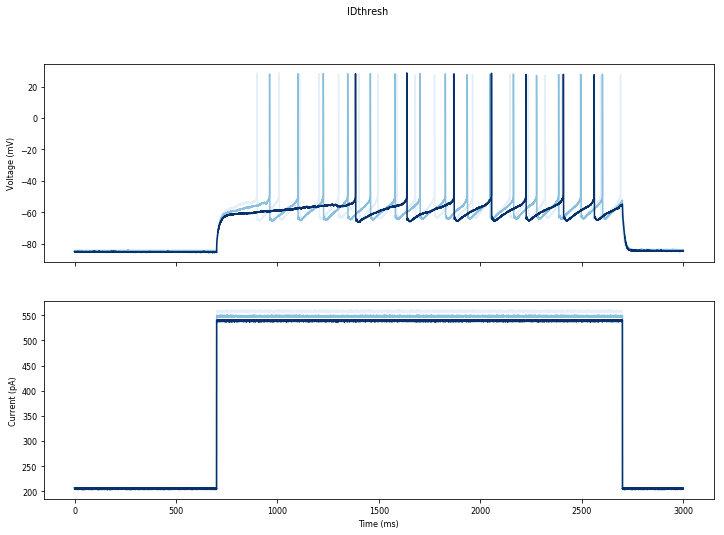

In [121]:
for recordings in repetitions[0:1]:
    currents = get_currents(cell, prefix, protocol, channels, recordings, 
                            timing={'stimulus_start': 700, 'stimulus_end': 2700})
    fig = plot_traces(cell, prefix, protocol, channels, recordings, 
                      vshift=liquid_junction_potential)
    figs.append(fig)

In [122]:
summary['fi_rheobase'] = rheo[1]

In [123]:
summary['fi_avg_minstim'] = f_i[0][0]
summary['fi_avg_fitslope'] = p[0]
summary['fi_avg_fitbaserate'] = p[1]+p[0]*xx[0]

In [124]:
summary['fi_1st_minstim'] = f_i1[0][0]
summary['fi_1st_fitslope'] = p1[0]
summary['fi_1st_fitbaserate'] = p1[1]+p1[0]*x1[0]

In [125]:
summary['fi_avg_rate_idlow'] = spec['cell_features']['IDthresh'][0][1]['mean_frequency'][0]
summary['fi_avg_rate_idmid'] = spec['cell_features']['IDthresh'][4][1]['mean_frequency'][0]
summary['fi_avg_rate_idhigh'] = spec['cell_features']['IDthresh'][-1][1]['mean_frequency'][0]
summary['fi_1st_rate_idlow'] = spec['cell_features']['IDthresh'][0][1]['inv_first_ISI'][0]
summary['fi_1st_rate_idmid'] = spec['cell_features']['IDthresh'][4][1]['inv_first_ISI'][0]
summary['fi_1st_rate_idhigh'] = spec['cell_features']['IDthresh'][-1][1]['inv_first_ISI'][0]

In [126]:
stim, feat = spec['cell_features']['APThreshold'][0]
summary['ap_threshold'] = feat['AP1_begin_voltage'][0]

In [127]:
ap_peak = []
ap_amplitude = []
ap_fall_rate = []
ap_rise_rate = []
ap_avg_thresh = []
spike_half_width = []
ahp_depth = []
ahp_depth_abs = []
ahp_depth_abs_slow = []
ahp_min_voltage = []
ahp_time_from_peak = []
ahp_slow_time = []
for stim, feat in spec['cell_features']['IDthresh']:
    ap_peak.extend(feat['peak_voltage'])
    ap_amplitude.extend(feat['AP_amplitude'])
    ap_fall_rate.extend(feat['AP_fall_rate'])
    ap_rise_rate.extend(feat['AP_rise_rate'])
    ap_avg_thresh.extend(feat['AP_begin_voltage'])
    spike_half_width.extend(feat['spike_half_width'])
    ahp_depth.extend(feat['AHP_depth'])
    ahp_depth_abs.extend(feat['AHP_depth_abs'])
    ahp_depth_abs_slow.extend(feat['AHP_depth_abs_slow'])
    ahp_min_voltage.extend(feat['min_voltage_between_spikes'])
    ahp_time_from_peak.extend(feat['AHP_time_from_peak'])
    ahp_slow_time.extend(feat['AHP_slow_time'])
    
ad_idlow = spec['cell_features']['IDthresh'][0][1]['adaptation_index2']
ad_idmid = spec['cell_features']['IDthresh'][4][1]['adaptation_index2']
ad_idhigh = spec['cell_features']['IDthresh'][-1][1]['adaptation_index2']
ap_delay_idlow = spec['cell_features']['IDthresh'][0][1]['time_to_first_spike']
ap_delay_idmid = spec['cell_features']['IDthresh'][4][1]['time_to_first_spike']
ap_delay_idhigh = spec['cell_features']['IDthresh'][-1][1]['time_to_first_spike']

In [128]:
summary['ap_peak'] = np.mean(ap_peak)
summary['ap_amplitude'] = np.mean(ap_amplitude)
summary['ap_fall_rate'] = np.mean(ap_fall_rate)
summary['ap_rise_rate'] = np.mean(ap_rise_rate)
summary['ap_avg_thresh'] = np.mean(ap_avg_thresh)
summary['ap_half_width'] = np.mean(spike_half_width)
summary['ahp_depth'] = np.mean(ahp_depth)
summary['ahp_depth_abs'] = np.mean(ahp_depth_abs)
summary['ahp_depth_abs_slow'] = np.mean(ahp_depth_abs_slow)
summary['ahp_min_voltage'] = np.mean(ahp_min_voltage)
summary['ahp_time_from_peak'] = np.mean(ahp_time_from_peak)
summary['ahp_slow_time'] = np.mean(ahp_slow_time)
summary['ad_idlow'] = np.mean(ad_idlow)
summary['ad_idmid'] = np.mean(ad_idmid)
summary['ad_idhigh'] = np.mean(ad_idhigh)
summary['ap_delay_idlow'] = np.mean(ap_delay_idlow)
summary['ap_delay_idmid'] = np.mean(ap_delay_idmid)
summary['ap_delay_idhigh'] = np.mean(ap_delay_idhigh)

In [129]:
ap_fall_rate = []
ap_rise_rate = []
for stim, feat in spec['cell_features']['APWaveform']:
    ap_fall_rate.extend(feat['AP_fall_rate'])
    ap_rise_rate.extend(feat['AP_rise_rate'])

In [130]:
summary['ap_fall_rate'] = np.mean(ap_fall_rate)
summary['ap_rise_rate'] = np.mean(ap_rise_rate)

In [131]:
stim, feat = spec['cell_features']['Delta'][0]
summary['tau_delta'] = feat['decay_time_constant_after_stim'][0]

In [132]:
stim, feat = spec['cell_features']['IRdepol'][0]
summary['tau_depol'] = feat['decay_time_constant_after_stim'][0]

In [133]:
stim, feat = spec['cell_features']['IRhyperpol'][0]
summary['tau_hyperpol'] = feat['decay_time_constant_after_stim'][0]

In [134]:
stim, feat = spec['cell_features']['IRrest'][0]
summary['tau_rest'] = feat['decay_time_constant_after_stim'][0]

In [135]:
stim, feat = spec['cell_features']['IRdepol'][0]
summary['ir_depol'] = feat['ohmic_input_resistance_vb_ssse'][0]

In [136]:
stim, feat = spec['cell_features']['IRhyperpol'][0]
summary['ir_hyperpol'] = feat['ohmic_input_resistance_vb_ssse'][0]

In [137]:
stim, feat = spec['cell_features']['IRrest'][0]
summary['ir_rest'] = feat['ohmic_input_resistance_vb_ssse'][0]

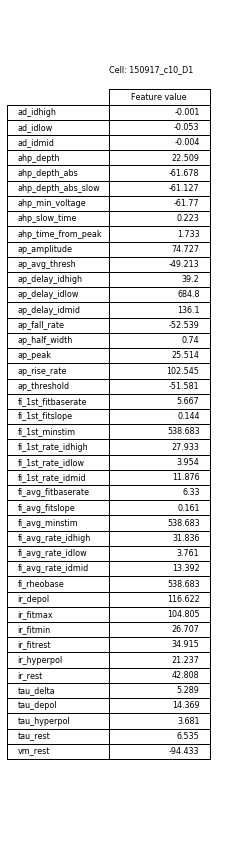

In [138]:
fig, ax = plt.subplots(figsize=(8,12))
ax.axis('off')
df = pandas.DataFrame(pandas.Series(summary))
ax.table(cellText=np.round(df.values, 3), loc='center',
         colLabels=['Feature value'], rowLabels=df.index)
legend = 'Cell: ' + spec['cell_id'] + '\n\n'
plt.text(0, 0.9, legend, horizontalalignment='left')
fig.tight_layout(rect=(0.25,0,0.5,1))
figs.append(fig)

## Saving results

In [139]:
save_figs(cell_id, figs)

In [140]:
save_spec(cell_id, spec)

In [141]:
save_summary(cell_id, summary)

In [142]:
save_protocols(config, spec)

In [143]:
save_features(config, spec)